<a href="https://colab.research.google.com/github/willw625731/ML-Molecular-Potentials/blob/master/active_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Google specific

from google.colab import drive
drive.mount('/content/drive')

# Imports and setup

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.autograd as autograd
import torch.utils.tensorboard
from collections import OrderedDict

import os
import math
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py

from numpy.random import default_rng
rng = default_rng()

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cd
!pwd
!ls drive/My\ Drive/Data/ANI_data
!ls sample_data/
!ls drive/My\ Drive/Data/ANI_data > drive/My\ Drive/Data/ANI_data/ANI_files
!mkdir sample_data/ANI_data
!cp drive/My\ Drive/Data/ANI_data/* sample_data/ANI_data

path = 'sample_data/ANI_data/'

with open('drive/My Drive/Data/ANI_data/ANI_files') as f:
    ds_files = f.read()
    ds_files = ds_files.split('\n')[1:-1]

print(ds_files)

for n, f in enumerate(ds_files):
    ds_files[n] = path+ds_files[n]

ds_files

In [0]:
# Important dataset info

group_lengths = {'ani_gdb_s01.h5': 3,
                 'ani_gdb_s02.h5': 13,
                 'ani_gdb_s03.h5': 20,
                 'ani_gdb_s04.h5': 61,
                 'ani_gdb_s05.h5': 267,
                 'ani_gdb_s06.h5': 1406,
                 'ani_gdb_s07.h5': 7760,
                 'ani_gdb_s08.h5': 47932}

group_last = {'ani_gdb_s01.h5': 3,
              'ani_gdb_s02.h5': 13,
              'ani_gdb_s03.h5': 20,
              'ani_gdb_s04.h5': 63,
              'ani_gdb_s05.h5': 275,
              'ani_gdb_s06.h5': 1408,
              'ani_gdb_s07.h5': 7850,
              'ani_gdb_s08.h5': 48319}

dnon_groups = {'ani_gdb_s01.h5': np.array([]),
 'ani_gdb_s02.h5': np.array([]),
 'ani_gdb_s03.h5': np.array([]),
 'ani_gdb_s04.h5': np.array(['gdb11_s04-50', 'gdb11_s04-53']),
 'ani_gdb_s05.h5': np.array(['gdb11_s05-38',
  'gdb11_s05-39',
  'gdb11_s05-40',
  'gdb11_s05-41',
  'gdb11_s05-175',
  'gdb11_s05-213',
  'gdb11_s05-214',
  'gdb11_s05-244']),
 'ani_gdb_s06.h5': np.array(['gdb11_s06-707', 'gdb11_s06-1116']),
 'ani_gdb_s07.h5': np.array(['gdb11_s07-40',
  'gdb11_s07-42',
  'gdb11_s07-382',
  'gdb11_s07-429',
  'gdb11_s07-507',
  'gdb11_s07-587',
  'gdb11_s07-593',
  'gdb11_s07-594',
  'gdb11_s07-642',
  'gdb11_s07-690',
  'gdb11_s07-722',
  'gdb11_s07-724',
  'gdb11_s07-732',
  'gdb11_s07-734',
  'gdb11_s07-736',
  'gdb11_s07-737',
  'gdb11_s07-1122',
  'gdb11_s07-1399',
  'gdb11_s07-1509',
  'gdb11_s07-1548',
  'gdb11_s07-1567',
  'gdb11_s07-1591',
  'gdb11_s07-1781',
  'gdb11_s07-1785',
  'gdb11_s07-1789',
  'gdb11_s07-1794',
  'gdb11_s07-1893',
  'gdb11_s07-1894',
  'gdb11_s07-1896',
  'gdb11_s07-1941',
  'gdb11_s07-1960',
  'gdb11_s07-2387',
  'gdb11_s07-2474',
  'gdb11_s07-2683',
  'gdb11_s07-2687',
  'gdb11_s07-2759',
  'gdb11_s07-3039',
  'gdb11_s07-3077',
  'gdb11_s07-3123',
  'gdb11_s07-3661',
  'gdb11_s07-3721',
  'gdb11_s07-3729',
  'gdb11_s07-3731',
  'gdb11_s07-4156',
  'gdb11_s07-4225',
  'gdb11_s07-4252',
  'gdb11_s07-4602',
  'gdb11_s07-4603',
  'gdb11_s07-4607',
  'gdb11_s07-4612',
  'gdb11_s07-4616',
  'gdb11_s07-4634',
  'gdb11_s07-4814',
  'gdb11_s07-4946',
  'gdb11_s07-4973',
  'gdb11_s07-5104',
  'gdb11_s07-5111',
  'gdb11_s07-5215',
  'gdb11_s07-5321',
  'gdb11_s07-5430',
  'gdb11_s07-5431',
  'gdb11_s07-5447',
  'gdb11_s07-5490',
  'gdb11_s07-5497',
  'gdb11_s07-5594',
  'gdb11_s07-5652',
  'gdb11_s07-5669',
  'gdb11_s07-5789',
  'gdb11_s07-5801',
  'gdb11_s07-5806',
  'gdb11_s07-5809',
  'gdb11_s07-5810',
  'gdb11_s07-5815',
  'gdb11_s07-5827',
  'gdb11_s07-5844',
  'gdb11_s07-5846',
  'gdb11_s07-5853',
  'gdb11_s07-5889',
  'gdb11_s07-6153',
  'gdb11_s07-6154',
  'gdb11_s07-6156',
  'gdb11_s07-6185',
  'gdb11_s07-6411',
  'gdb11_s07-6606',
  'gdb11_s07-6644',
  'gdb11_s07-7101',
  'gdb11_s07-7254',
  'gdb11_s07-7401',
  'gdb11_s07-7780',
  'gdb11_s07-7784']),
 'ani_gdb_s08.h5': np.array(['gdb11_s08-38',
  'gdb11_s08-44',
  'gdb11_s08-301',
  'gdb11_s08-314',
  'gdb11_s08-604',
  'gdb11_s08-606',
  'gdb11_s08-608',
  'gdb11_s08-610',
  'gdb11_s08-611',
  'gdb11_s08-612',
  'gdb11_s08-693',
  'gdb11_s08-1001',
  'gdb11_s08-1002',
  'gdb11_s08-1007',
  'gdb11_s08-1008',
  'gdb11_s08-1050',
  'gdb11_s08-1120',
  'gdb11_s08-1229',
  'gdb11_s08-1666',
  'gdb11_s08-1700',
  'gdb11_s08-1850',
  'gdb11_s08-1969',
  'gdb11_s08-2048',
  'gdb11_s08-2345',
  'gdb11_s08-2464',
  'gdb11_s08-3120',
  'gdb11_s08-3306',
  'gdb11_s08-3311',
  'gdb11_s08-3321',
  'gdb11_s08-3393',
  'gdb11_s08-3396',
  'gdb11_s08-3404',
  'gdb11_s08-3486',
  'gdb11_s08-3580',
  'gdb11_s08-3618',
  'gdb11_s08-3639',
  'gdb11_s08-3641',
  'gdb11_s08-3842',
  'gdb11_s08-3926',
  'gdb11_s08-3927',
  'gdb11_s08-3930',
  'gdb11_s08-3939',
  'gdb11_s08-3959',
  'gdb11_s08-3960',
  'gdb11_s08-4857',
  'gdb11_s08-5038',
  'gdb11_s08-5088',
  'gdb11_s08-5141',
  'gdb11_s08-5172',
  'gdb11_s08-5181',
  'gdb11_s08-5243',
  'gdb11_s08-5261',
  'gdb11_s08-5274',
  'gdb11_s08-5284',
  'gdb11_s08-5598',
  'gdb11_s08-5606',
  'gdb11_s08-5607',
  'gdb11_s08-5610',
  'gdb11_s08-5613',
  'gdb11_s08-5630',
  'gdb11_s08-5640',
  'gdb11_s08-5641',
  'gdb11_s08-5662',
  'gdb11_s08-5724',
  'gdb11_s08-5736',
  'gdb11_s08-5738',
  'gdb11_s08-5829',
  'gdb11_s08-5835',
  'gdb11_s08-5898',
  'gdb11_s08-5993',
  'gdb11_s08-5999',
  'gdb11_s08-6005',
  'gdb11_s08-6230',
  'gdb11_s08-6290',
  'gdb11_s08-6445',
  'gdb11_s08-6519',
  'gdb11_s08-6565',
  'gdb11_s08-6709',
  'gdb11_s08-6975',
  'gdb11_s08-6976',
  'gdb11_s08-6996',
  'gdb11_s08-6999',
  'gdb11_s08-7004',
  'gdb11_s08-7029',
  'gdb11_s08-7243',
  'gdb11_s08-7423',
  'gdb11_s08-7535',
  'gdb11_s08-7620',
  'gdb11_s08-7977',
  'gdb11_s08-8165',
  'gdb11_s08-8373',
  'gdb11_s08-8394',
  'gdb11_s08-8666',
  'gdb11_s08-8802',
  'gdb11_s08-8828',
  'gdb11_s08-8903',
  'gdb11_s08-8963',
  'gdb11_s08-8975',
  'gdb11_s08-9294',
  'gdb11_s08-9325',
  'gdb11_s08-9552',
  'gdb11_s08-9683',
  'gdb11_s08-9880',
  'gdb11_s08-9956',
  'gdb11_s08-9966',
  'gdb11_s08-9999',
  'gdb11_s08-10018',
  'gdb11_s08-10040',
  'gdb11_s08-10089',
  'gdb11_s08-10130',
  'gdb11_s08-10723',
  'gdb11_s08-10815',
  'gdb11_s08-10890',
  'gdb11_s08-10915',
  'gdb11_s08-10950',
  'gdb11_s08-11143',
  'gdb11_s08-11167',
  'gdb11_s08-11721',
  'gdb11_s08-11722',
  'gdb11_s08-11725',
  'gdb11_s08-11727',
  'gdb11_s08-11789',
  'gdb11_s08-11790',
  'gdb11_s08-12030',
  'gdb11_s08-12059',
  'gdb11_s08-12093',
  'gdb11_s08-12094',
  'gdb11_s08-12270',
  'gdb11_s08-12515',
  'gdb11_s08-12806',
  'gdb11_s08-12954',
  'gdb11_s08-13213',
  'gdb11_s08-13472',
  'gdb11_s08-13476',
  'gdb11_s08-13506',
  'gdb11_s08-13541',
  'gdb11_s08-13584',
  'gdb11_s08-13881',
  'gdb11_s08-13933',
  'gdb11_s08-14033',
  'gdb11_s08-14087',
  'gdb11_s08-14093',
  'gdb11_s08-14102',
  'gdb11_s08-14132',
  'gdb11_s08-14554',
  'gdb11_s08-14597',
  'gdb11_s08-14634',
  'gdb11_s08-14780',
  'gdb11_s08-14820',
  'gdb11_s08-14821',
  'gdb11_s08-14822',
  'gdb11_s08-14828',
  'gdb11_s08-14829',
  'gdb11_s08-14898',
  'gdb11_s08-14914',
  'gdb11_s08-14921',
  'gdb11_s08-14930',
  'gdb11_s08-14960',
  'gdb11_s08-14987',
  'gdb11_s08-14992',
  'gdb11_s08-15003',
  'gdb11_s08-15012',
  'gdb11_s08-15017',
  'gdb11_s08-15166',
  'gdb11_s08-15179',
  'gdb11_s08-15180',
  'gdb11_s08-15586',
  'gdb11_s08-15829',
  'gdb11_s08-16717',
  'gdb11_s08-16969',
  'gdb11_s08-16974',
  'gdb11_s08-16991',
  'gdb11_s08-17086',
  'gdb11_s08-17252',
  'gdb11_s08-17300',
  'gdb11_s08-17309',
  'gdb11_s08-17320',
  'gdb11_s08-17327',
  'gdb11_s08-17330',
  'gdb11_s08-17562',
  'gdb11_s08-17581',
  'gdb11_s08-17656',
  'gdb11_s08-17746',
  'gdb11_s08-17755',
  'gdb11_s08-17765',
  'gdb11_s08-17787',
  'gdb11_s08-17869',
  'gdb11_s08-18030',
  'gdb11_s08-18121',
  'gdb11_s08-18173',
  'gdb11_s08-18431',
  'gdb11_s08-18596',
  'gdb11_s08-18722',
  'gdb11_s08-18900',
  'gdb11_s08-19182',
  'gdb11_s08-19546',
  'gdb11_s08-19973',
  'gdb11_s08-20207',
  'gdb11_s08-20218',
  'gdb11_s08-20242',
  'gdb11_s08-20254',
  'gdb11_s08-20279',
  'gdb11_s08-20386',
  'gdb11_s08-20821',
  'gdb11_s08-21012',
  'gdb11_s08-21092',
  'gdb11_s08-21361',
  'gdb11_s08-21567',
  'gdb11_s08-21791',
  'gdb11_s08-21801',
  'gdb11_s08-21827',
  'gdb11_s08-21891',
  'gdb11_s08-21987',
  'gdb11_s08-22048',
  'gdb11_s08-22092',
  'gdb11_s08-22112',
  'gdb11_s08-22216',
  'gdb11_s08-22297',
  'gdb11_s08-22322',
  'gdb11_s08-22428',
  'gdb11_s08-22587',
  'gdb11_s08-22742',
  'gdb11_s08-22765',
  'gdb11_s08-23153',
  'gdb11_s08-23185',
  'gdb11_s08-23221',
  'gdb11_s08-23230',
  'gdb11_s08-23547',
  'gdb11_s08-23876',
  'gdb11_s08-23919',
  'gdb11_s08-24034',
  'gdb11_s08-24057',
  'gdb11_s08-24204',
  'gdb11_s08-25032',
  'gdb11_s08-25185',
  'gdb11_s08-26020',
  'gdb11_s08-26027',
  'gdb11_s08-26162',
  'gdb11_s08-26167',
  'gdb11_s08-26299',
  'gdb11_s08-26324',
  'gdb11_s08-26475',
  'gdb11_s08-26730',
  'gdb11_s08-26950',
  'gdb11_s08-27374',
  'gdb11_s08-27509',
  'gdb11_s08-27689',
  'gdb11_s08-27721',
  'gdb11_s08-27804',
  'gdb11_s08-28548',
  'gdb11_s08-28549',
  'gdb11_s08-28552',
  'gdb11_s08-28557',
  'gdb11_s08-28558',
  'gdb11_s08-29046',
  'gdb11_s08-29048',
  'gdb11_s08-29054',
  'gdb11_s08-29120',
  'gdb11_s08-29121',
  'gdb11_s08-29129',
  'gdb11_s08-29251',
  'gdb11_s08-29350',
  'gdb11_s08-29512',
  'gdb11_s08-29513',
  'gdb11_s08-29516',
  'gdb11_s08-29525',
  'gdb11_s08-29555',
  'gdb11_s08-29578',
  'gdb11_s08-29589',
  'gdb11_s08-29684',
  'gdb11_s08-29749',
  'gdb11_s08-29884',
  'gdb11_s08-29984',
  'gdb11_s08-30066',
  'gdb11_s08-30076',
  'gdb11_s08-30225',
  'gdb11_s08-30254',
  'gdb11_s08-30285',
  'gdb11_s08-30324',
  'gdb11_s08-30351',
  'gdb11_s08-30643',
  'gdb11_s08-30877',
  'gdb11_s08-30881',
  'gdb11_s08-30882',
  'gdb11_s08-30888',
  'gdb11_s08-31083',
  'gdb11_s08-31785',
  'gdb11_s08-31791',
  'gdb11_s08-31985',
  'gdb11_s08-32018',
  'gdb11_s08-32077',
  'gdb11_s08-32078',
  'gdb11_s08-32094',
  'gdb11_s08-32302',
  'gdb11_s08-32908',
  'gdb11_s08-32949',
  'gdb11_s08-32967',
  'gdb11_s08-33221',
  'gdb11_s08-33608',
  'gdb11_s08-33785',
  'gdb11_s08-33865',
  'gdb11_s08-33937',
  'gdb11_s08-33938',
  'gdb11_s08-33944',
  'gdb11_s08-33945',
  'gdb11_s08-33957',
  'gdb11_s08-33960',
  'gdb11_s08-33968',
  'gdb11_s08-33970',
  'gdb11_s08-34108',
  'gdb11_s08-34153',
  'gdb11_s08-34230',
  'gdb11_s08-34254',
  'gdb11_s08-34375',
  'gdb11_s08-34609',
  'gdb11_s08-34628',
  'gdb11_s08-34652',
  'gdb11_s08-34660',
  'gdb11_s08-34668',
  'gdb11_s08-34672',
  'gdb11_s08-34686',
  'gdb11_s08-34689',
  'gdb11_s08-34692',
  'gdb11_s08-34723',
  'gdb11_s08-34776',
  'gdb11_s08-34795',
  'gdb11_s08-34796',
  'gdb11_s08-34904',
  'gdb11_s08-34907',
  'gdb11_s08-34951',
  'gdb11_s08-35168',
  'gdb11_s08-35266',
  'gdb11_s08-35276',
  'gdb11_s08-35294',
  'gdb11_s08-35297',
  'gdb11_s08-35298',
  'gdb11_s08-35302',
  'gdb11_s08-35317',
  'gdb11_s08-35325',
  'gdb11_s08-35326',
  'gdb11_s08-35337',
  'gdb11_s08-35340',
  'gdb11_s08-36019',
  'gdb11_s08-36337',
  'gdb11_s08-36501',
  'gdb11_s08-36777',
  'gdb11_s08-36837',
  'gdb11_s08-36951',
  'gdb11_s08-37603',
  'gdb11_s08-37606',
  'gdb11_s08-37655',
  'gdb11_s08-37700',
  'gdb11_s08-37702',
  'gdb11_s08-37705',
  'gdb11_s08-37821',
  'gdb11_s08-37836',
  'gdb11_s08-37841',
  'gdb11_s08-37993',
  'gdb11_s08-38519',
  'gdb11_s08-38520',
  'gdb11_s08-38860',
  'gdb11_s08-39108',
  'gdb11_s08-39212',
  'gdb11_s08-39522',
  'gdb11_s08-39857',
  'gdb11_s08-40055',
  'gdb11_s08-40348',
  'gdb11_s08-40769',
  'gdb11_s08-41109',
  'gdb11_s08-41210',
  'gdb11_s08-41435',
  'gdb11_s08-41546',
  'gdb11_s08-41904',
  'gdb11_s08-41913',
  'gdb11_s08-41916',
  'gdb11_s08-41963',
  'gdb11_s08-42082',
  'gdb11_s08-42623',
  'gdb11_s08-43080',
  'gdb11_s08-44231',
  'gdb11_s08-45347',
  'gdb11_s08-45548',
  'gdb11_s08-46032',
  'gdb11_s08-46133',
  'gdb11_s08-47167',
  'gdb11_s08-48051',
  'gdb11_s08-48131'])}



In [0]:
# Active loader

head_path = '../../../Data/ANI-1_release/'

group_lengths = {'ani_gdb_s01.h5': 3,
                 'ani_gdb_s02.h5': 13,
                 'ani_gdb_s03.h5': 20,
                 'ani_gdb_s04.h5': 61,
                 'ani_gdb_s05.h5': 267,
                 'ani_gdb_s06.h5': 1406,
                 'ani_gdb_s07.h5': 7760,
                 'ani_gdb_s08.h5': 47932}

group_scounts = {'ani_gdb_s01.h5': 2970,
                 'ani_gdb_s02.h5': 1898,
                 'ani_gdb_s03.h5': 2511,
                 'ani_gdb_s04.h5': 2264,
                 'ani_gdb_s05.h5': 1914,
                 'ani_gdb_s06.h5': 1463,
                 'ani_gdb_s07.h5': 565,
                 'ani_gdb_s08.h5': 456}

group_index = {'ani_gdb_s01.h5': 0,
               'ani_gdb_s02.h5': 1,
               'ani_gdb_s03.h5': 2,
               'ani_gdb_s04.h5': 3,
               'ani_gdb_s05.h5': 4,
               'ani_gdb_s06.h5': 5,
               'ani_gdb_s07.h5': 6,
               'ani_gdb_s08.h5': 7}

dsets = list(group_lengths.keys())
dset_p = np.ones(len(dsets))/len(dsets)

# Training hyperparameters

threshold = torch.tensor([1e-3])
batch = 400
n_eval = 5
n_train = 5

def species_converter(species):
    mapping = {'H':0, 'C':1, 'N':2, 'O':3}
    return map(mapping.get, species)

def get_sce(path, group_num):
    head_group = 'gdb11_s0{}'.format(path[-4])
    tail_group = '{}-{}'.format(head_group, str(group_num))
    full_group = '{}/{}'.format(head_group, tail_group)
    mapping = {'H':0, 'C':1, 'N':2, 'O':3}
    with h5py.File(path, 'r') as f:
        hf = f[full_group]
        s = np.array([mapping[sp] for sp in [s.decode('ascii') for s in hf['species']]])
        c = np.array(hf['coordinates'])
        e = np.array(hf['energies'])
        s, c, e = torch.tensor(s), torch.tensor(c), torch.tensor(e)
    return s, c, e

def random_dset(num):
    return np.random.choice(dsets, size=num, p=dset_p)

def random_mols(dset, num):
    return [n for n in np.random.randint(group_last[dset], size=num)]

def random_data(head_path):
    while True:
        dset = np.random.choice(dsets, p=dset_p)
        n = np.random.randint(group_last[dset])
        group = 'gdb11_s0{}-{}'.format(dset[-4], str(n))
        if not (group in dnon_groups[dset]):
            break
    data = get_sce(head_path+dset, n)
    return data, dset

def p_update():
    for n, d in enumerate(dsets):
        dset_p[n] = 1.0/float(group_scounts[d])
    tot = sum(dset_p)
    for n, p in enumerate(dset_p):
        dset_p[n] = p/tot



#################################################################################


def data_output(path, name, data):
    out_lines = []
    for line in data:
        out_lines += [','.join([str(x) for x in line])]
        
    out_file = '\n'.join(out_lines)
    with open(path+name, 'a+') as f:
        f.write('\n'+out_file)


def evaluate(model, data, slices):
    rng = np.random.default_rng()
    s,c,e = data[0], data[1], data[2]
    slice_index = rng.choice(c.shape[0], size=slices, replace=False)
    cs, es = c[slice_index], e[slice_index].squeeze()
    ss = torch.einsum("ik,j->ijk", [torch.ones(cs.shape[0], 1), s])

    model = model.eval()
    epred = model((ss, cs))

    loss = 0.5*torch.norm((epred-es),p=2)**2
    return loss

def train(model, data, slices, optimizer):
    rng = np.random.default_rng()
    s,c,e = data[0], data[1], data[2]
    slice_index = rng.choice(c.shape[0], size=slices, replace=False)
    cs, es = c[slice_index], e[slice_index].squeeze()
    ss = torch.einsum("ik,j->ijk", [torch.ones(cs.shape[0], 1), s])

    model = model.train()
    epred = model((ss, cs))

    loss = 0.5*torch.norm((epred-es),p=2)**2
    return loss

def backprop(loss):
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def fit(epochs, threshold, batch, n_eval, n_train):
    load_model('drive/My Drive/train/models/', model_name, 'train')
    loss_line = []
    for epoch in tqdm.notebook.tqdm(range(epochs+1), total=epochs+1):
        if epoch%5 == 0:
            data_output('drive/My Drive/train/loss/', '{}_loss'.format(model_name), loss_line)
            loss_line = []
            save_model('drive/My Drive/train/models/', model_name)

        mols, counter = 0, 0
        loss = torch.empty(batch)
        while mols < batch:
            skips = 0
            counter += 1
            if counter > batch*1.5:
                break
            data, dset = random_data('sample_data/ANI_data/')
            if data != None:
                error = evaluate(model, data, n_eval)
                if error > threshold:
                    loss[mols] = train(model, data, n_train, optimizer)
                    mols += 1
                else:
                    group_scounts[dset] += 1
                    p_update()
                    skips += 1
                    if (skips/batch) > 0.10:
                        threshold *= 0.8
                    continue
            else:
                continue
        all_loss = torch.einsum("i->", loss)/loss.shape[0]
        loss_line += [[epoch, all_loss.clone().detach().item()]]
        backprop(all_loss)
    
def get_model():
    model = full_model(torch.eye(3), [20,1000,1000,1000], [1000,500,200,1], 4).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    return model, optimizer, criterion

def load_model(path, model_name, state):
    checkpoint = torch.load('{}model_{}.pth'.format(path, model_name))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if state == 'eval':
        model.eval()
    if state == 'train':
        model.train()

def save_model(path, model_name):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
                '{}model_{}.pth'.format(path, model_name))
    

# Dataset loading


HARTREE_TO_EV = 27.211386024367243  # equal to ase.units.Hartree
EV_TO_JOULE = 1.6021766208e-19  # equal to ase.units._e (electron charge)
JOULE_TO_KCAL = 1 / 4184.  # exact
HARTREE_TO_JOULE = HARTREE_TO_EV * EV_TO_JOULE
AVOGADROS_NUMBER = 6.022140857e+23  # equal to ase.units._Nav
SPEED_OF_LIGHT = 299792458.0  # equal to ase.units._c
AMU_TO_KG = 1.660539040e-27  # equal to ase.units._amu
ANGSTROM_TO_METER = 1e-10
NEWTON_TO_MILLIDYNE = 1e8  # exact relation
HARTREE_TO_KCALMOL = HARTREE_TO_JOULE * JOULE_TO_KCAL * AVOGADROS_NUMBER
HARTREE_TO_KJOULEMOL = HARTREE_TO_JOULE * AVOGADROS_NUMBER / 1000
EV_TO_KCALMOL = EV_TO_JOULE * JOULE_TO_KCAL * AVOGADROS_NUMBER
EV_TO_KJOULEMOL = EV_TO_JOULE * AVOGADROS_NUMBER / 1000

eners = torch.tensor([ -0.6126, -38.0601, -54.7065, -75.1870])

def hartree2kcalmol(x):
    r"""Hartree to kJ/mol conversion factor from CODATA 2014"""
    return x * HARTREE_TO_KCALMOL

cart2tet = torch.tensor([[1.0,1.0,1.0],[-1.0,-1.0,1.0],[-1.0,1.0,-1.0],[-1.0,-1.0,-1.0]])/torch.sqrt(torch.tensor(3.0))

In [0]:
# General model

class prep(nn.Module):
    def __init__(self, coord_transform=torch.eye(3), atomtypes=4):
        super(prep, self).__init__()
        self.ct = coord_transform
        self.atomtypes = atomtypes

    def species_onehot(self, species):
        return torch.eye(self.atomtypes)[species.type(torch.LongTensor)].squeeze()

    def coordinate_transform(self, coords, transform):
        return torch.einsum("...ij,kj->...ik", [coords, transform])

    def species_transform(self, species, transform):
        return transform[species.type(torch.LongTensor)]

    def random_coord_rotation(self, coords, sigma=torch.tensor([20.0])):
        x_r = torch.normal(mean=0, std=sigma)
        y_r = torch.normal(mean=0, std=sigma)
        z_r = torch.normal(mean=0, std=sigma)

        cx, sx = torch.cos(x_r), torch.sin(x_r)
        cy, sy = torch.cos(y_r), torch.sin(y_r)
        cz, sz = torch.cos(z_r), torch.sin(z_r)

        r_x = torch.tensor([[1., 0., 0.], [0., cx, -sx], [0., sx, cx]])
        r_y = torch.tensor([[cy, 0., sy], [0., 1., 0.], [-sy, 0., cy]])
        r_z = torch.tensor([[cz, -sz, 0.], [sz, cz, 0.], [0., 0., 1.]])

        r_t = torch.transpose(r_x @ r_y @ r_z, 0, 1)

        rot_coords = torch.einsum("...ij,jk->...ik", [coords, r_t])
        return rot_coords

    def forward(self, data):
        coords = self.random_coord_rotation(data[1])
        dim = coords.shape[-2] 
        species = data[0]     # N
        rot_coords = self.random_coord_rotation(coords)             # shape N*3
        t_coords = self.coordinate_transform(rot_coords, self.ct)   # shape N*TC
        t_species = self.species_onehot(species.squeeze())#          # shape N*TS

        t_s = torch.cat((torch.einsum("...ij,k->...kij", [t_species, torch.ones(dim)]), torch.einsum("...ij,k->...ikj", [t_species, torch.ones(dim)])), -1)
        t_c = torch.einsum("...ij,k->...kij", [t_coords, torch.ones(dim)]) - torch.einsum("...ij,k->...ikj", [t_coords, torch.ones(dim)])
        t_d = torch.einsum("...ij,k->...ijk", [torch.sqrt(torch.einsum("...ijk,...ijk->...ij", [t_c, t_c])), torch.ones(t_c.shape[-1])])
        t_d[t_d==0] = 100
        
        t_ang = t_c/t_d                                         # shape N*N*TC
        t_i = 1/t_d                                             # same as t_ang
        t_i2 = torch.einsum("...ijk,...ijk->...ijk", [t_i, t_i])         # same as t_ang
        t_i3 = torch.einsum("...ijk,...ijk->...ijk", [t_i, t_i2])        # same as t_ang
        t_i4 = torch.einsum("...ijk,...ijk->...ijk", [t_i2, t_i2])       # same as t_ang
        t_i5 = torch.einsum("...ijk,...ijk->...ijk", [t_i2, t_i3])       # same as t_ang
        t_i6 = torch.einsum("...ijk,...ijk->...ijk", [t_i3, t_i3])       # same as t_ang

        final = torch.cat((t_s, t_ang, t_i, t_i2, t_i6), -1)
        mask = torch.einsum("ij,k->ijk", [torch.eye(dim), torch.ones(final.shape[-1])])
        mask[mask==1]=2
        mask[mask==0]=1
        mask[mask==2]=0
        return final * mask


class printer(nn.Module):
    def __init__(self, params=[10, 10, 10]):
        super(printer, self).__init__()

        self.act = nn.ReLU()

        self.ws = nn.ParameterList([nn.Parameter(torch.empty(params[n], params[n+1])) for n in range(len(params)-1)])
        self.ps = nn.ParameterList([nn.Parameter(torch.empty(params[n+1])) for n in range(len(params)-1)])
        self.bs = nn.ParameterList([nn.Parameter(torch.zeros(params[n+1])) for n in range(len(params)-1)])

        for w in self.ws:
            nn.init.xavier_normal_(w)

        for p in self.ps:
            nn.init.normal_(p, std=0.00001)

    def forward(self, x):
        for i, w in enumerate(self.ws):
            x = self.act(torch.einsum("...ijk,kl->...ijl", [x, w]) + self.bs[i])
            x = torch.einsum("...ijk,k,l->...ijl", [x, self.ps[i], torch.ones(self.ps[i].shape[0])]) + x
        return x


class atom_centered(nn.Module):
    def __init__(self, params=[10, 10, 1]):
        super(atom_centered, self).__init__()
        self.act = nn.ReLU()

        self.ws = nn.ParameterList([nn.Parameter(torch.empty(sum(params[:n+1]), params[n+1])) for n in range(len(params)-1)])
        self.bs = nn.ParameterList([nn.Parameter(torch.zeros(params[n+1])) for n in range(len(params)-1)])

        for w in self.ws:
            nn.init.xavier_normal_(w)

    def forward(self, x):
        for i in range(len(self.ws)-1):
            buffer = self.act(torch.einsum("...ij,jk->...ik", [x, self.ws[i]]) + self.bs[i])
            x = torch.cat((x, buffer), -1)
        x = torch.einsum("...ij,jk->...ik", [x, self.ws[-1]]) + self.bs[-1]
        return x


class self_energy(nn.Module):
    def __init__(self, self_energies):
        super(self_energy, self).__init__()
        self.se = self_energies

    def forward(self, species):
        return self.se[species]

class energy_tune(nn.Module):
    def __init__(self, n_species=4):
        super(energy_tune, self).__init__()
        self.n_species = n_species
        #self.w = nn.Parameter(torch.zeros(n_species))
        self.w = torch.tensor([ -0.6126, -38.0601, -54.7065, -75.1870])

    def forward(self, species, energy):
        one_hot = torch.eye(self.n_species)[species].squeeze()
        adj_ener = torch.einsum("...ij,j->...i", [one_hot, self.w]).unsqueeze(-1) + energy
        return adj_ener


class full_model(nn.Module):
    def __init__(self, c_transform, p_params, a_params, s_rep):
        super(full_model, self).__init__()
        a_params[0] += s_rep

        self.pair_prep = prep(c_transform)
        self.printer = printer(p_params)
        self.a_cent = atom_centered(a_params)
        self.e_tune = energy_tune()

        self.atomtypes = 4

    def species_onehot(self, species):
        return torch.eye(self.atomtypes)[species.type(torch.LongTensor)].squeeze()

    def forward(self, data):
        species = data[0].type(torch.LongTensor)
        species_rep = self.species_onehot(species)

        base_rep = self.pair_prep(data)
        env_rep = torch.einsum("...ijk->...ik", self.printer(base_rep))
        atom_rep = torch.cat((species_rep, env_rep), -1)
        atom_env_energy = self.a_cent(atom_rep)
        atom_adj_energy = self.e_tune(species, atom_env_energy)

        system_energy = torch.einsum("...ij->...j", atom_adj_energy)
        return system_energy
        

model = full_model(torch.eye(3), [20,100,200,500], [500,250,100,1], 4).to(device)

In [0]:
# Training

#model = energy_ensemble().to(device)

lr = 1e-6
epochs = 400
epoch = 0
wd = 0.0001

optimizer = optim.AdamW(model.parameters(), lr, weight_decay=wd)
criterion = nn.MSELoss()

model_name = 'full_eye_active_test_004'
#save_model('drive/My Drive/train/models/', model_name)
load_model('drive/My Drive/train/models/', model_name, 'train')

#fit(epochs, threshold, batch, n_eval, n_train)

In [0]:
data_n = [None, None, None]
data_n[0] = data[0]
data_n[1] = data[1][:12]
data_n[2] = data[2][:12]

In [0]:
model

full_model(
  (pair_prep): prep()
  (printer): printer(
    (act): ReLU()
    (ws): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 20x100]
        (1): Parameter containing: [torch.FloatTensor of size 100x200]
        (2): Parameter containing: [torch.FloatTensor of size 200x500]
    )
    (ps): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 100]
        (1): Parameter containing: [torch.FloatTensor of size 200]
        (2): Parameter containing: [torch.FloatTensor of size 500]
    )
    (bs): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 100]
        (1): Parameter containing: [torch.FloatTensor of size 200]
        (2): Parameter containing: [torch.FloatTensor of size 500]
    )
  )
  (a_cent): atom_centered(
    (act): ReLU()
    (ws): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 504x250]
        (1): Parameter containing: [torch.FloatTensor of size 754x100]
   

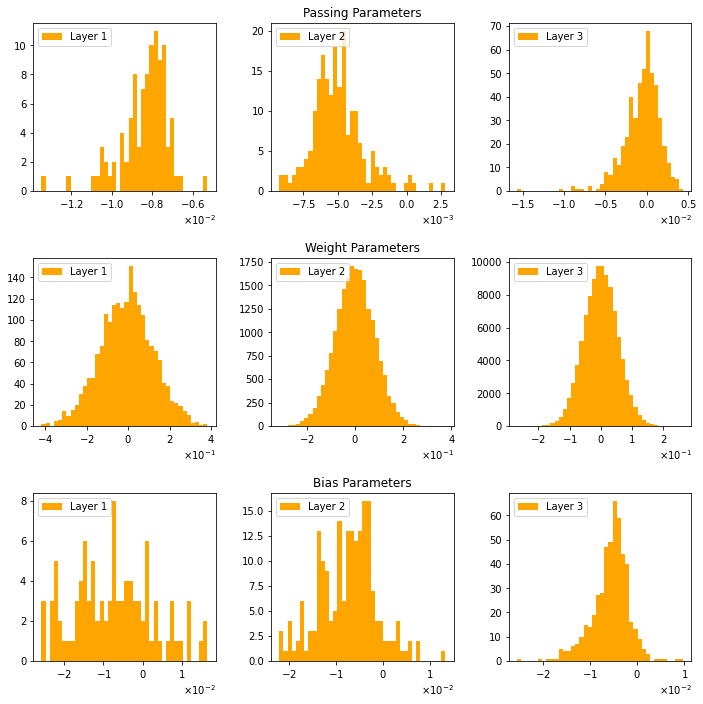

In [0]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=[10,10])
for n, param in enumerate(model.printer.ps):
    ax[0,n].hist(param.detach().numpy().flatten(), bins=40, label='Layer '+str(n+1), color='orange')
    ax[0,n].ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
    ax[0,n].legend(loc=2)
for n, param in enumerate(model.printer.ws):
    ax[1,n].hist(param.detach().numpy().flatten(), bins=40, label='Layer '+str(n+1), color='orange')
    ax[1,n].ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
    ax[1,n].legend(loc=2)
for n, param in enumerate(model.printer.bs):
    ax[2,n].hist(param.detach().numpy().flatten(), bins=40, label='Layer '+str(n+1), color='orange')
    ax[2,n].ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
    ax[2,n].legend(loc=2)

ax[0,1].set_title('Passing Parameters')
ax[1,1].set_title('Weight Parameters')
ax[2,1].set_title('Bias Parameters')
fig.tight_layout(pad=1.5)
plt.savefig("drive/My Drive/train/figs/improved_dset_net_parameters_small.png", format="png", dpi=400)

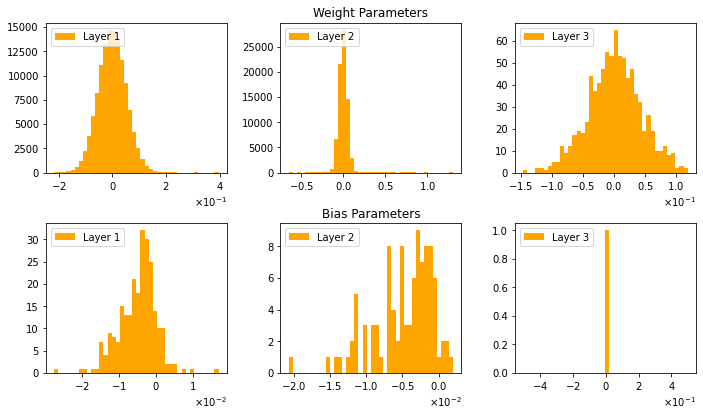

In [0]:

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[10,6])
for n, param in enumerate(model.a_cent.ws):
    ax[0,n].hist(param.detach().numpy().flatten(), bins=40, label='Layer '+str(n+1), color='orange')
    ax[0,n].ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
    ax[0,n].legend(loc=2)
for n, param in enumerate(model.a_cent.bs):
    ax[1,n].hist(param.detach().numpy().flatten(), bins=40, label='Layer '+str(n+1), color='orange')
    ax[1,n].ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
    ax[1,n].legend(loc=2)

ax[0,1].set_title('Weight Parameters')
ax[1,1].set_title('Bias Parameters')
fig.tight_layout(pad=1.5)
plt.savefig("drive/My Drive/train/figs/improved_dset_acent_parameters_small.png", format="png", dpi=400)

In [0]:
model.e_tune.w

Parameter containing:
tensor([-6.4753e-05, -3.6358e-05, -4.1290e-05, -3.2127e-05],
       requires_grad=True)

In [0]:
group_scounts

{'ani_gdb_s01.h5': 2970,
 'ani_gdb_s02.h5': 1898,
 'ani_gdb_s03.h5': 2511,
 'ani_gdb_s04.h5': 2264,
 'ani_gdb_s05.h5': 1914,
 'ani_gdb_s06.h5': 1463,
 'ani_gdb_s07.h5': 565,
 'ani_gdb_s08.h5': 456}

In [0]:
threshold

NameError: ignored

In [0]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

In [0]:
params

326205